In [1]:
from IPython import get_ipython


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import time

np.random.seed(42)
tf.random.set_seed(42)

history_points=50

tf.__version__

# import dataset from alpha vantage as example csv
# from util import csv_to_dataset, history_points, btc_csv_to_dataset

# ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('AAPL_daily.csv')
# ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = btc_csv_to_dataset('BTC-USD_daily.csv')
# ohlcv = open, high, low, close, volume



'2.3.1'

In [3]:
#preprocessing
import pandas as pd
import ta

# Load data
# df = pd.read_csv('./data/BTC-USD_daily.csv', parse_dates=['time'])
df = pd.read_csv('./data/BTC_USD-2012-01-01_to_2020-12-31.csv', parse_dates=['time'])

df['date'] = pd.to_datetime(df['time'], unit='s')
df.dropna()
# df.reset_index()
df.set_index('date', inplace=True)
df.drop('time', axis=1, inplace=True)
df = df[["open", "high", "low", "close", "volume"]] # make sure we only have ohlcv values


split = 0.5 # remove first half of data, prior to 2016
n = int(df.shape[0] * split)
df = df[n:]
df.head()



open    high     low   close     volume
date                                                          
2016-07-03 09:52:00  675.34  675.34  675.31  675.31   1.568861
2016-07-03 09:53:00  675.23  675.23  674.39  674.39   1.049194
2016-07-03 09:54:00  675.21  675.21  675.20  675.20   0.289629
2016-07-03 09:55:00  674.39  674.39  672.15  672.15  20.833446
2016-07-03 09:56:00  672.53  672.53  672.15  672.15  16.000000

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(20,8))
# sns.lineplot(x=df.index, y='open', data=df).set_title('BTC')



Text(0.5, 1.0, 'BTC downsampled')

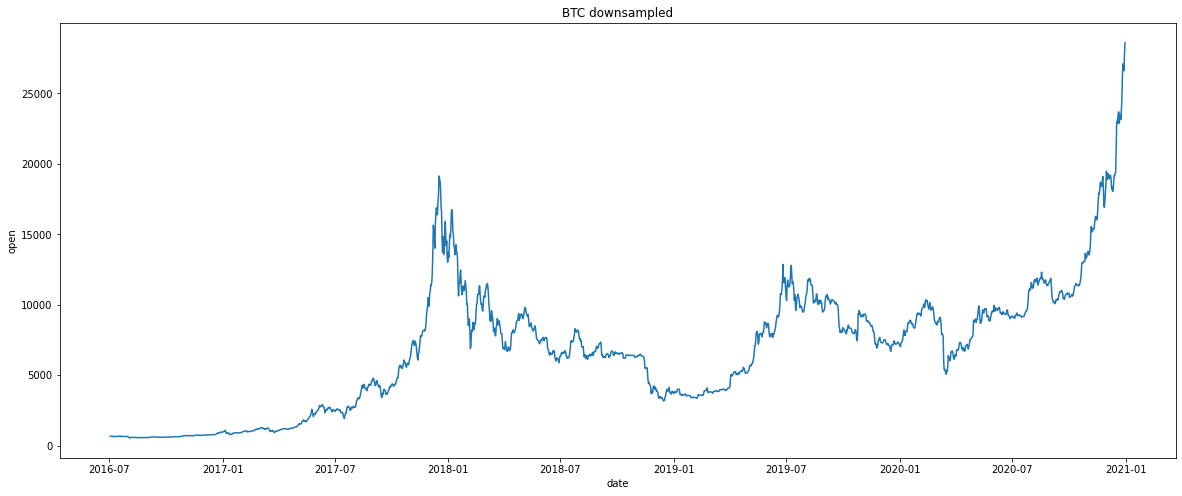

In [5]:
plt.figure(figsize=(20,8))
resample_rate = '20H'
data = df.resample(resample_rate).mean()
sns.lineplot(x=data.index, y='open', data=data).set_title('BTC downsampled')



Text(0.5, 1.0, 'BTC downsampled')

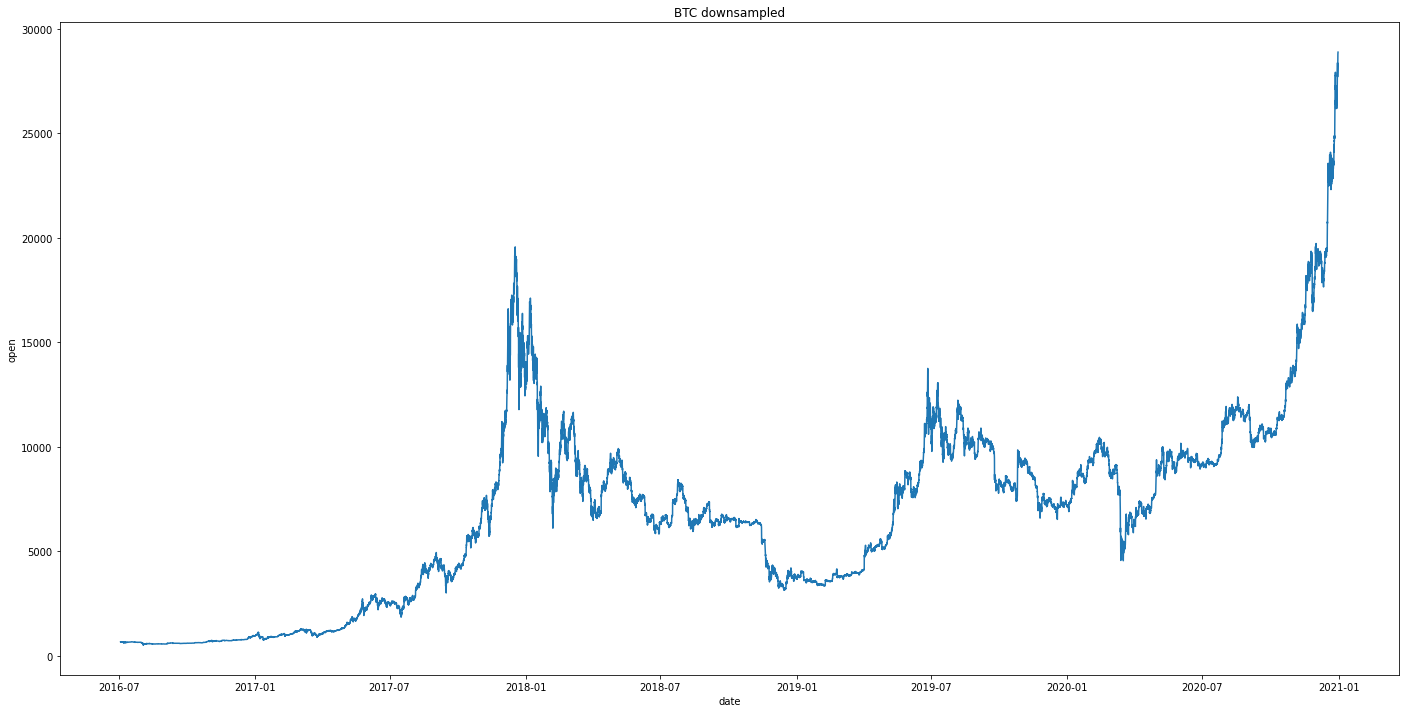

In [6]:
plt.figure(figsize=(24,12))
resample_rate = '1H'
data = df.resample(resample_rate).mean()
sns.lineplot(x=data.index, y='open', data=data).set_title('BTC downsampled')



In [7]:
# Clean na values
data = ta.utils.dropna(data)
print(df.columns)

# Add all ta features filling nans values
data = ta.add_all_ta_features(data, "open", "high", "low", "close", "volume", fillna=True)
data.head()
data.to_csv('./data/BTC-USD-1H-resampled-with-TA.csv')



Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


<AxesSubplot:xlabel='date', ylabel='volatility_kch'>

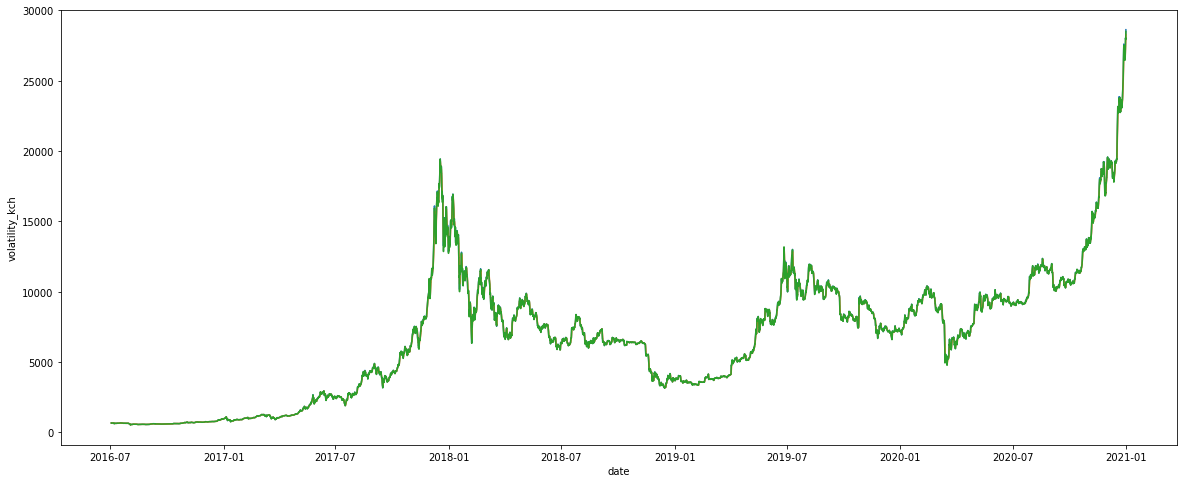

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(20,8))
sns.lineplot(x=data.index, y='volatility_kch', data=data)
sns.lineplot(x=data.index, y='volatility_bbm', data=data)
sns.lineplot(x=data.index, y='trend_ichimoku_conv', data=data)



In [9]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_df(df):
    df = df.dropna()
    df = df.fillna(method="ffill")
    # df = df.pct_change()
    ohlcv_histories = df[df.columns[:5]] # data[["open", "high", "low", "close", "volume"]]
    technical_indicators = df[df.columns[5:]] # the generated technical indicators

    all_scaler = MinMaxScaler()
    all_indicators = df.values
    all_indicators = all_scaler.fit_transform(all_indicators)
    all_indicators = np.array([all_indicators[i:i + history_points].copy() for i in range(len(all_indicators) - history_points)])

    print(ohlcv_histories.shape)
    print(technical_indicators.shape)
    x_scaler = MinMaxScaler()
    data_values = ohlcv_histories.values
    data_normalised = x_scaler.fit_transform(data_values)



    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    print(ohlcv_normalised.shape)



    y_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    y_normalised = np.expand_dims(y_normalised, -1)
    print(y_normalised.shape)

    unscaled_y = np.array([data_values[:, 0][i + history_points].copy() for i in range(len(df) - history_points)])
    unscaled_y = np.expand_dims(unscaled_y, -1)
    print('unscaled_y', unscaled_y.shape)

    y_scaler = MinMaxScaler()
    y_scaler.fit(unscaled_y)

    print(technical_indicators.shape)
    technical_indicators = technical_indicators[:len(ohlcv_normalised)]
    print(technical_indicators.shape)

    tech_ind_scaler = MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)
    print(technical_indicators_normalised.shape)
    
    
    assert ohlcv_normalised.shape[0] == unscaled_y.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_normalised, technical_indicators_normalised, y_normalised, unscaled_y, y_scaler, all_indicators



In [10]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser, all_indicators = preprocess_df(data)
# ohlcv = open, high, low, close, volume

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)
print(tech_ind_train.shape)
print(tech_ind_test.shape)
print(f"ohlcv_test:{len(ohlcv_test)}")
print(f"tech_ind_test:{len(tech_ind_test)}")



(39396, 5)
(39396, 83)
(39346, 50, 5)
(39346, 1)
unscaled_y (39346, 1)
(39396, 83)
(39346, 83)
(39346, 83)
(35411, 50, 5)
(3935, 50, 5)
(35411, 83)
(3935, 83)
ohlcv_test:3935
tech_ind_test:3935


In [11]:
# ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser, all_indicators = preprocess_df(data)
# # ohlcv = open, high, low, close, volume

# test_split = 0.9
# n = int(ohlcv_histories.shape[0] * test_split)

# ohlcv_train = all_indicators[:n]
# y_train = next_day_open_values[:n]

# ohlcv_test = all_indicators[n:]
# y_test = next_day_open_values[n:]

# unscaled_y_test = unscaled_y[n:]

# print(ohlcv_train.shape)
# print(ohlcv_test.shape)
# # print(tech_ind_train.shape)
# # print(tech_ind_test.shape)
# print(f"ohlcv_test:{len(ohlcv_test)}")
# print(f"tech_ind_test:{len(y_train)}")
# # model architecture



In [12]:

# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(256, name='lstm_0', return_sequences=True)(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = BatchNormalization(name='batch_norm_0')(x)

x = LSTM(256, name='lstm_1')(x)
x = Dropout(0.1, name='lstm_dropout_1')(x)
x = BatchNormalization(name='batch_norm_1')(x)

# model.add(LSTM(64))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
x = Dense(128, name='dense_output_0', activation='relu')(x)
x = Dropout(0.2, name='dense_dropout_0')(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(256, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.1, name='tech_dropout_0')(y)

y = Dense(256, name='tech_dense_1')(dense_input)
y = Activation("relu", name='tech_relu_1')(y)
y = Dropout(0.2, name='tech_dropout_1')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(128, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
model.compile(optimizer='adam', loss='mse')

name = f"seq_len[{history_points}]-15m-t{int(time.time())}"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))
filepath = "models/acc-{val_accuracy:.3f}-{epoch:02d}.h5"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # saves only the best ones


model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)



Epoch 1/50
996/996 [==============================] - 12s 12ms/step - loss: 0.0018 - val_loss: 5.0251e-04
Epoch 2/50
996/996 [==============================] - 11s 11ms/step - loss: 5.5309e-04 - val_loss: 1.9794e-04
Epoch 3/50
996/996 [==============================] - 11s 11ms/step - loss: 4.6497e-04 - val_loss: 9.3894e-05
Epoch 4/50
996/996 [==============================] - 12s 12ms/step - loss: 4.2824e-04 - val_loss: 2.7640e-04
Epoch 5/50
996/996 [==============================] - 12s 12ms/step - loss: 6.1085e-04 - val_loss: 4.3509e-04
Epoch 6/50
996/996 [==============================] - 11s 11ms/step - loss: 5.1076e-04 - val_loss: 9.2842e-04
Epoch 7/50
996/996 [==============================] - 11s 11ms/step - loss: 7.9668e-04 - val_loss: 3.8977e-04
Epoch 8/50
996/996 [==============================] - 11s 11ms/step - loss: 4.7871e-04 - val_loss: 3.8550e-04
Epoch 9/50
996/996 [==============================] - 11s 11ms/step - loss: 4.7189e-04 - val_loss: 3.5864e-04
Epoch 10/50
99

In [ ]:
plt.figure(figsize=(20,8))
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')
plt.legend(['Real', 'Predicted'])



In [ ]:
y_predicted



In [ ]:
predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([ohlcv_histories, technical_indicators]))) 
buys = []
sells = []
thresh = 7.77
tr_perc = 1.11
print(predicted_price_tomorrow)
start = 0
end = -1

x = -1

# for prediction in predicted_price_tomorrow:

# for ohlcv, tech_ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
for i, ohlcv in enumerate(ohlcv_histories[start:end-6]):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)[0][0]
    price_tomorrow = predicted_price_tomorrow[i+6]
    # delta = price_tomorrow - price_today
    delta = price_tomorrow / price_today
   # print( price_tomorrow, price_today)

    if  (price_tomorrow / price_today) > tr_perc:
        buys.append((x, price_today))
    elif  (price_today / price_tomorrow) > tr_perc:
        sells.append((x, price_today))
    
    # if  price_tomorrow > (price_today*thresh):
    #     buys.append((x, price_today))
    # elif price_tomorrow < (price_today*thresh):
    #     sells.append((x, price_today))

    # if delta > thresh:
    #     buys.append((x, price_today))
    # elif delta < -thresh:
    #     sells.append((x, price_today))
    x += 1
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")



In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

print(unscaled_y)
real = plt.plot(unscaled_y[int(len(unscaled_y)*0.75):end], label='real')
pred = plt.plot(y_predicted[int(len(unscaled_y)*0.75):end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])
plt.figure(figsize=(100,40))
plt.show()
model.save('./models/huge-lstm-dense.h5')




3935
94140.7478760079


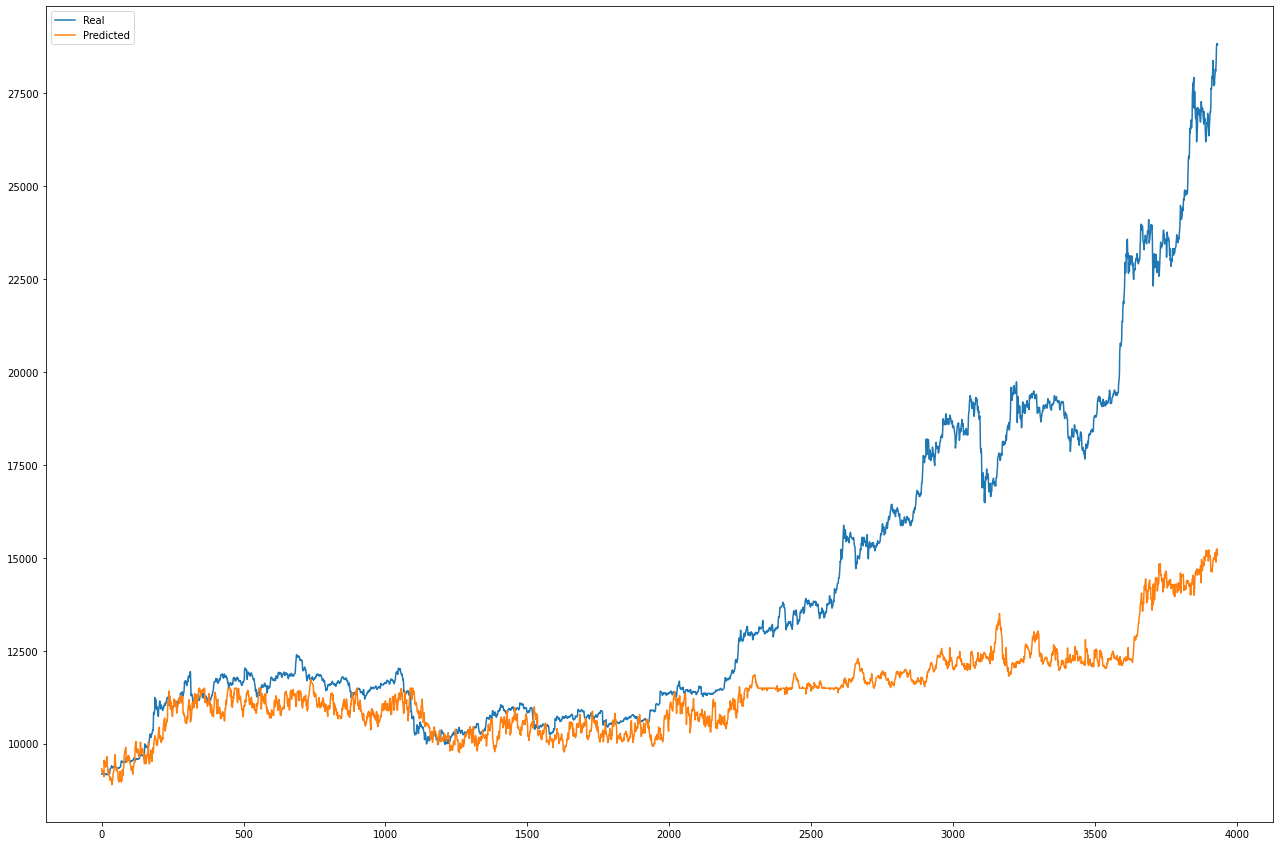

In [18]:

# evaluation
print(len(tech_ind_test))
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

import time
model.save(f'./models/ohlcv-ind-{time.time()}.h5')



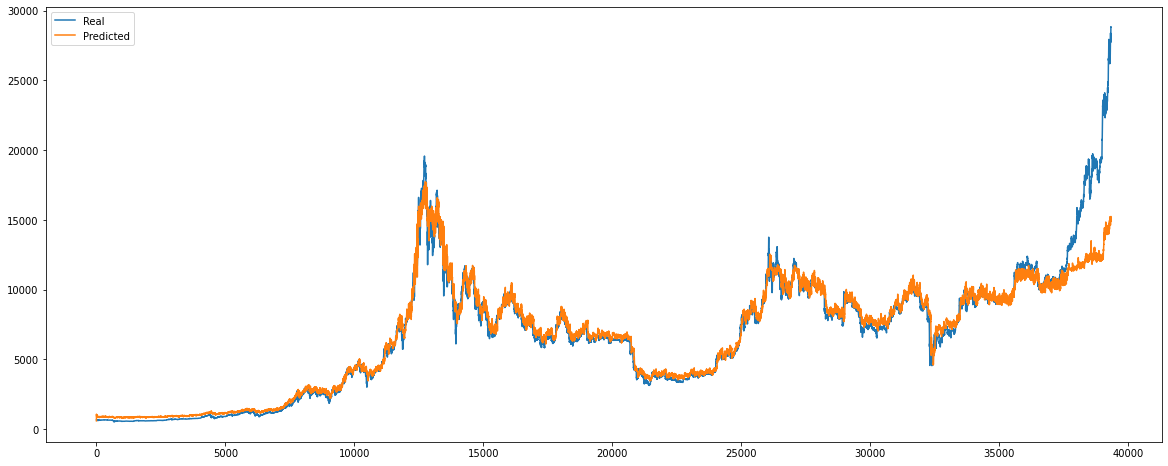

In [19]:
plt.figure(figsize=(20,8))
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')
plt.legend(['Real', 'Predicted'])



In [20]:
y_predicted



array([[  600.6642],
       [ 1079.7991],
       [ 1075.7876],
       ...,
       [15113.779 ],
       [15079.412 ],
       [14872.845 ]], dtype=float32)

In [21]:
predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([ohlcv_histories, technical_indicators]))) 
buys = []
sells = []
thresh = 7.77
tr_perc = 1.11
print(predicted_price_tomorrow)
start = 0
end = -1

x = -1

# for prediction in predicted_price_tomorrow:

# for ohlcv, tech_ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
for i, ohlcv in enumerate(ohlcv_histories[start:end-6]):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)[0][0]
    price_tomorrow = predicted_price_tomorrow[i+6]
    # delta = price_tomorrow - price_today
    delta = price_tomorrow / price_today
   # print( price_tomorrow, price_today)

    if  (price_tomorrow / price_today) > tr_perc:
        buys.append((x, price_today))
    elif  (price_today / price_tomorrow) > tr_perc:
        sells.append((x, price_today))
    
    # if  price_tomorrow > (price_today*thresh):
    #     buys.append((x, price_today))
    # elif price_tomorrow < (price_today*thresh):
    #     sells.append((x, price_today))

    # if delta > thresh:
    #     buys.append((x, price_today))
    # elif delta < -thresh:
    #     sells.append((x, price_today))
    x += 1
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")



[  600.6642  1079.7991  1075.7876 ... 15113.779  15079.412  14872.845 ]
buys: 10047
sells: 1951


earnings: $42879616.328021556
[[  671.53622222]
 [  674.19444444]
 [  672.46906977]
 ...
 [28820.0405    ]
 [28810.286     ]
 [28893.21      ]]


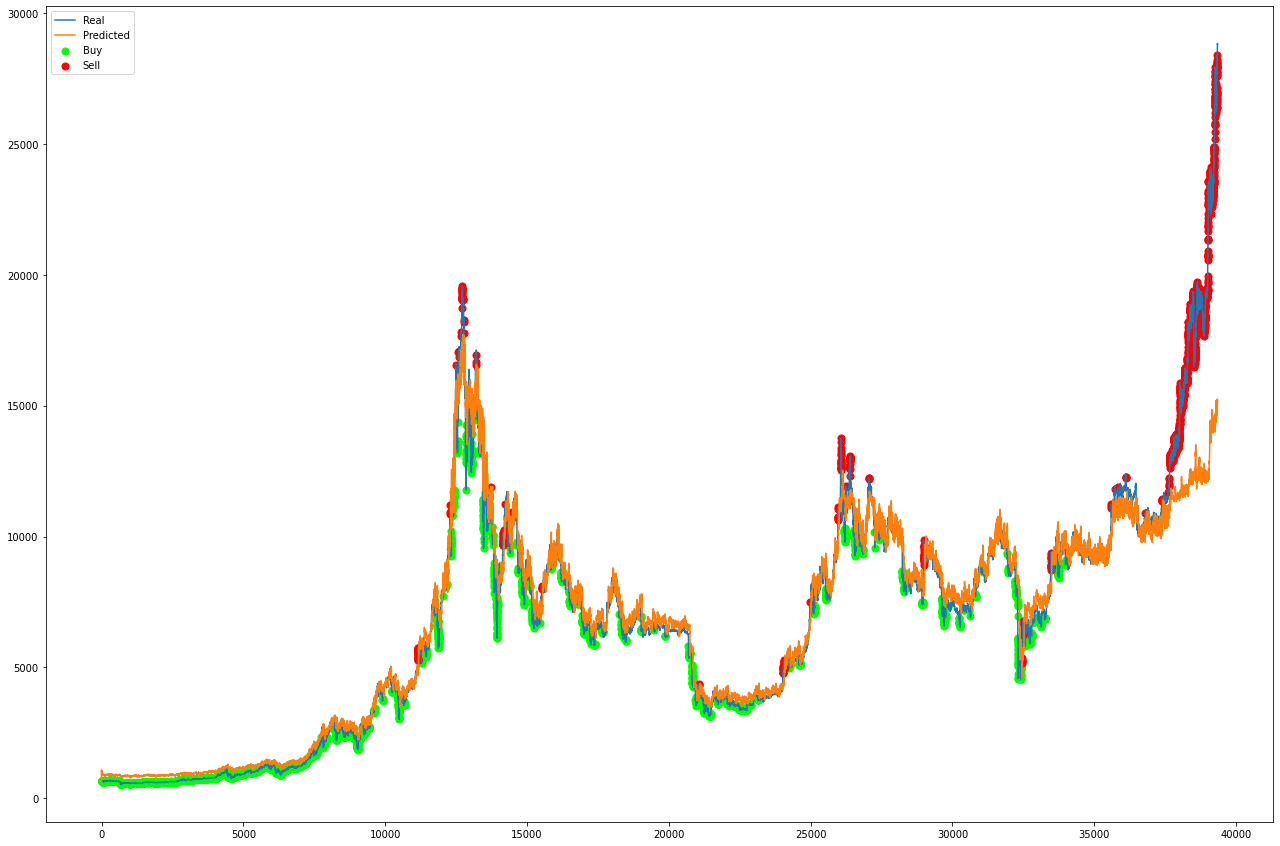

<Figure size 7200x2880 with 0 Axes>

In [22]:
def compute_earnings(buys_, sells_):
    purchase_amt = 1000
    stock = 0
    balance = 0
    while len(buys_) > 0 and len(sells_) > 0:
        if buys_[0][0] < sells_[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys_[0][1]
            buys_.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells_[0][1]
            stock = 0
            sells_.pop(0)
    print(f"earnings: ${balance}")


# we create new lists so we dont modify the original
compute_earnings([b for b in buys], [s for s in sells])

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

print(unscaled_y)
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])
plt.figure(figsize=(100,40))
plt.show()
model.save('./models/huge-lstm-dense.h5')



[[  671.53622222]
 [  674.19444444]
 [  672.46906977]
 ...
 [28820.0405    ]
 [28810.286     ]
 [28893.21      ]]


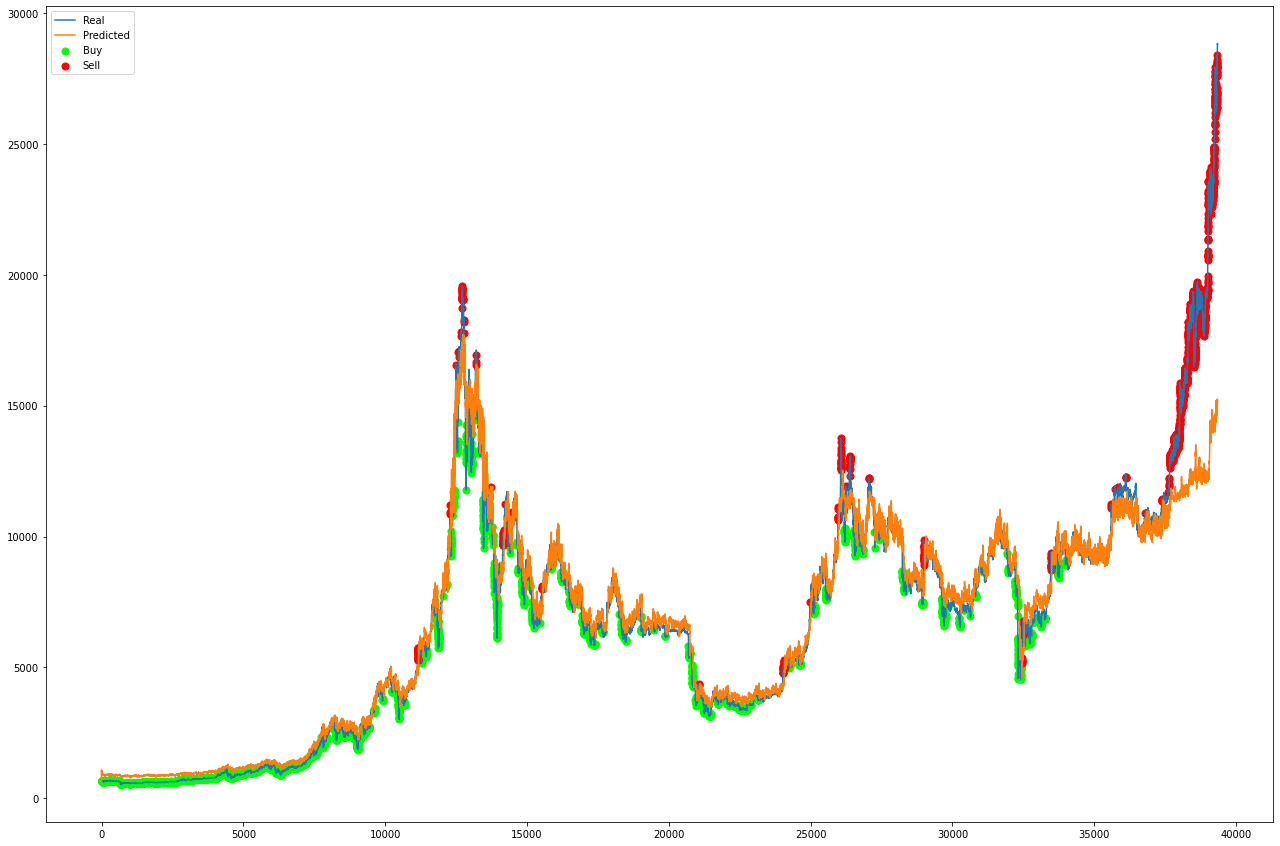

<Figure size 7200x3600 with 0 Axes>

In [29]:
plt.gcf().set_size_inches(22, 15, forward=True)

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

print(unscaled_y)
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])
plt.figure(figsize=(100,50))
plt.show()
model.save('./models/huge-lstm-dense.h5')


